### Regression

In [ ]:
#| default_exp statistics.regression

In [ ]:
#| export
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.utils.estimator_checks import check_estimator


In [ ]:
#| hide
import matplotlib.pyplot as plt

In [ ]:
#| export

EPSILON = 1e-6

class LOESSRegression(BaseEstimator, RegressorMixin):
    """scikit-learn estimator which implements a LOESS style local polynomial regression. The number of basis functions or kernels can be explicitly defined which allows for faster and cheaper training and inference.
        
    Parameters
    ----------

    n_kernels : int 
        default = 6, The number of local polynomial functions used to approximate the data. The location and extend of the kernels will be distributed to contain an equal number of datapoints in the training set.

    kernel_size : float
        default = 2, A factor increasing the kernel size to overlap with the neighboring kernel.

    polynomial_degree : int
        default = 2, Degree of the polynomial functions used for the local approximation.

    """

    def __init__(self, 
                n_kernels: int = 6, 
                kernel_size: float = 2., 
                polynomial_degree: int = 2):

        self.n_kernels = n_kernels
        self.kernel_size = kernel_size
        self.polynomial_degree = polynomial_degree

    def get_params(self, deep: bool = True):
        return super().get_params(deep)

    def set_params(self, **params):
        return super().set_params(**params)

    def _more_tags(self):
        return {'X_types': ['1darray']}

    def calculate_kernel_indices(self, x: np.ndarray):
        """Determine the indices of the datapoints belonging to each kernel.

        Parameters
        ----------
        x : numpy.ndarray
            float, of shape (n_datapoints)

        Returns
        -------
        numpy.ndarray, int
            of shape (n_kernels, 2)
        
        """

        num_datapoints = len(x)
        interval_size = num_datapoints // self.n_kernels

        start = np.arange(0,self.n_kernels) * interval_size
        end = start + interval_size

        interval_extension  = ((interval_size * self.kernel_size - interval_size) //2)

        start = start - interval_extension
        start = np.maximum(0,start)

        end = end + interval_extension
        end = np.minimum(num_datapoints,end)

        return np.column_stack([start,end]).astype(int)

    
    def fit(self, x: np.ndarray, y: np.ndarray):
        """fit the model passed on provided training data.
        
        Parameters
        ----------

        x : numpy.ndarray
            float, of shape (n_samples,) or (n_samples, 1), Training data. Note that only a single feature is supported at the moment.

        y : numpy.ndarray, float
            of shape (n_samples,) or (n_samples, 1) Target values.

        Returns
        -------

        self: object
            Returns the fitted estimator.

        """
        
        # As required by scikit-learn estimator guidelines
        self.n_features_in_ = 1

        # Does not yet work with more than one input dimension
        # axis-wise scaling and improved distance function need to be implemented
        if len(x.shape) > 1:
            if x.shape[1] > 1:
                raise ValueError('Input arrays with more than one feature not yet supported. Please provide a matrix of shape (n_datapoints, 1) or (n_datapoints,)')

        # create flat version of the array for 
        idx_sorted = np.argsort(x.flat)
        x_sorted = x.flat[idx_sorted]

        if len(x.shape) == 1:
            x = x[...,np.newaxis]

        if len(y.shape) == 1:
            y = y[...,np.newaxis]

        # kernel indices will only be calculated during fitting
        kernel_indices = self.calculate_kernel_indices(x_sorted)

        # scale max and scale mean will then be used for calculating the weighht matrix
        self.scale_mean = np.zeros((self.n_kernels))
        self.scale_max = np.zeros((self.n_kernels))

        # scale mean and max are calculated and contain the scaling before applying the kernel
        for i, area in enumerate(kernel_indices):
            area_slice = slice(*area)
            self.scale_mean[i] = x_sorted[area_slice].mean()
            self.scale_max[i] = np.max(np.abs(x_sorted[area_slice] - self.scale_mean[i]))

        # from here on, the original column arrays are used
        w = self.get_weight_matrix(x)

        # build design matrix
        polynomial_transform = PolynomialFeatures(self.polynomial_degree)
        x_design = polynomial_transform.fit_transform(x)
        number_of_dimensions = len(x_design[0])

        self.beta = np.zeros((number_of_dimensions,self.n_kernels))

        for i, weights in enumerate(w.T):

            loadings = np.linalg.inv(x_design.T * weights @ x_design)@x_design.T
            beta = (loadings*weights)@y
            y_m = np.sum(x_design @ beta, axis=1)
            self.beta[:,i] = np.ravel((loadings*weights)@y)
        
        return self

    def predict(self, x: np.ndarray):
        """Predict using the LOESS model.
        
        Parameters
        ----------

        x : numpy.ndarray
            float, of shape (n_samples,) or (n_samples, 1) Feature data. Note that only a single feature is supported at the moment.
        
        Returns
        -------

        y : numpy.ndarray, float
        of shape (n_samples,)
            Target values.

        """

        if len(x.shape) == 1:
            x = x[...,np.newaxis]

        w = self.get_weight_matrix(x)
        polynomial_transform = PolynomialFeatures(self.polynomial_degree)
        x_design = polynomial_transform.fit_transform(x)

        return np.sum(x_design @ self.beta * w, axis=1)
        

    def get_weight_matrix(self, x: np.ndarray):
        """Applies the fitted scaling parameter and the kernel to yield a weight matrix.

        The weight matrix is calculated based on the self.scale_mean and self.scale_max parameters which need to be calculated before calling this function.
        They define the center and extend of the tricubic kernels. The first and last column are one-padded at the start and beginning to allow for extrapolation. 

        Parameters
        ----------

        x: numpy.ndarray
            Numpy array of shape (n_datapoints, 1) which should be transformed to weights.


        Returns
        -------
        
        numpy.ndarray
            Weight matrix with the shape (n_datapoints, n_kernels).
        
        """
        w = np.tile(x,(1,self.n_kernels))

        w = np.abs(w - self.scale_mean)
        w = w/self.scale_max
        
        # apply weighting kernel
        w = self.tricubic(w)
        
       #perform epsilon padding at the start and end of the weight matrix to allow for extrapolation.
        # START
        idx_values = np.where(w[:,0] > 0)[0]
        if len(idx_values) > 0:
            min_idx, max_idx = idx_values[[0, -1]]
            w[:min_idx,0] = EPSILON

        # END
        idx_values = np.where(w[:,-1] > 0)[0]
        if len(idx_values) > 0:
            min_idx, max_idx = idx_values[[0, -1]]
            w[max_idx:,-1] = EPSILON

        # normalize column wise

        w = w/np.sum(w, axis=1, keepdims=True)

        return w
        

    @staticmethod
    def tricubic(x):
        """tricubic weight kernel"""
        epsilon = EPSILON
        mask = np.abs(x) <= 1
        return mask * (np.power(1-np.power(np.abs(x),3),3) + epsilon)
 

In [ ]:
#|hide
from nbdev.showdoc import show_doc

In [ ]:
show_doc(LOESSRegression.fit)

---

[source](https://github.com/MannLabs/alphabase/blob/main/alphabase/statistics/regression.py#L85){target="_blank" style="float:right; font-size:smaller"}

### LOESSRegression.fit

>      LOESSRegression.fit (x:numpy.ndarray, y:numpy.ndarray)

fit the model passed on provided training data.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | ndarray | float, of shape (n_samples,) or (n_samples, 1), Training data. Note that only a single feature is supported at the moment. |
| y | ndarray | of shape (n_samples,) or (n_samples, 1) Target values. |
| **Returns** | **self: object** | **Returns the fitted estimator.** |

In [ ]:
show_doc(LOESSRegression.predict)

---

[source](https://github.com/MannLabs/alphabase/blob/main/alphabase/statistics/regression.py#L156){target="_blank" style="float:right; font-size:smaller"}

### LOESSRegression.predict

>      LOESSRegression.predict (x:numpy.ndarray)

Predict using the LOESS model.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | ndarray | float, of shape (n_samples,) or (n_samples, 1) Feature data. Note that only a single feature is supported at the moment. |
| **Returns** | **numpy.ndarray, float** |  |

### Application example

In [ ]:
#| hide
check_estimator(LOESSRegression())

/Users/georgwallmann/miniconda3/envs/alphadia/lib/python3.8/site-packages/sklearn/utils/estimator_checks.py:290: SkipTestWarning: Can't test estimator LOESSRegression which requires input  of type ['1darray']
  warnings.warn(


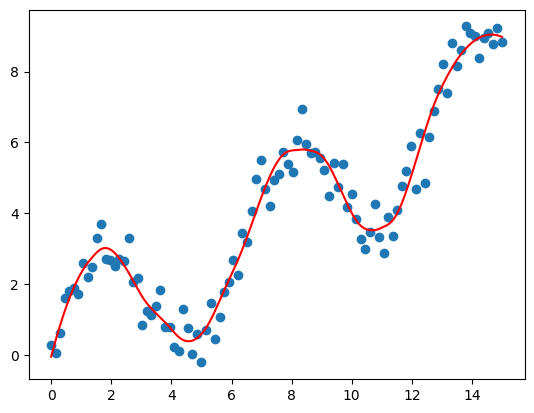

In [ ]:

def noisy_1d(x):
    y = np.sin(x)
    y_err = np.random.normal(y,0.5)
    return y + y_err + 0.5 * x

x_train = np.linspace(0,15,100)
y_train = noisy_1d(x_train)

x_test = np.linspace(0,15,200)
y_test = LOESSRegression().fit(x_train, y_train).predict(x_test)

plt.scatter(x_train,y_train)
plt.plot(x_test,y_test,c='r')
plt.show()